# Winery classification with the multivariate Gaussian

## 1. Load in the data 

In [1]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal 

In [22]:
# Load data set.
data = np.loadtxt('Documents/Machine_learning/winery-multivariate/wine.data.txt', delimiter=',')
# Names of features
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']
# Split 178 instances into training set (trainx, trainy) of size 130 and test set (testx, testy) of size 48
np.random.seed(0)
perm = np.random.permutation(178)
trainx = data[perm[0:130],1:14]
trainy = data[perm[0:130],0]
testx = data[perm[130:178], 1:14]
testy = data[perm[130:178],0]

## 2. Fit a Gaussian generative model

For each class (`j=1,2,3`), we have:
* `pi[j]`: the class weight
* `mu[j,:]`: the mean, a 13-dimensional vector
* `sigma[j,:,:]`: the 13x13 covariance matrix

This means that `pi` is a 4x1 array (Python arrays are indexed starting at zero, and we aren't using `j=0`), `mu` is a 4x13 array and `sigma` is a 4x13x13 array.

In [23]:
def fit_generative_model(x,y):
    k = 3  # labels 1,2,...,k
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k+1,d))
    sigma = np.zeros((k+1,d,d))
    pi = np.zeros(k+1)
    for label in range(1,k+1):
        indices = (y == label)
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=0, bias=1)
        pi[label] = float(sum(indices))/float(len(y))
    return mu, sigma, pi

In [24]:
mu, sigma, pi = fit_generative_model(trainx,trainy)

## 3. Use the model to make predictions on the test set

In [25]:
def test_model(mu, sigma, pi, features, tx, ty):
    if len(features) != len(np.unique(features)):
        print("Please choose different features")
        return
   
    k = 3 # Labels 1,2,...,k
    nt = len(ty) # Number of test points
    score = np.zeros((nt,k+1))
    for i in range(0,nt):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + \
            multivariate_normal.logpdf(tx[i,features], mean=mu[label,features], cov=sigma[label][np.ix_(features,features)])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    errors = str(np.sum(predictions != ty)) + '/'+ str(len(ty))
    return errors

In [26]:
test_model(mu, sigma, pi, [2,4,6], testx, testy)

'7/48'

In [27]:
test_model(mu, sigma, pi, [2], testx, testy)

'29/48'

In [28]:
test_model(mu, sigma, pi, [0,2], testx, testy)

'12/48'

In [29]:
test_model(mu, sigma, pi, [0,2,6], testx, testy)

'3/48'

In [30]:
test_model(mu, sigma, pi, range(0,13), testx, testy)

'2/48'

# Gaussian generative models for handwritten digit classification

## 1. Set up notebook and load in data

In [32]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal
from urllib.request import urlretrieve

In [33]:
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [34]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [35]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [36]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

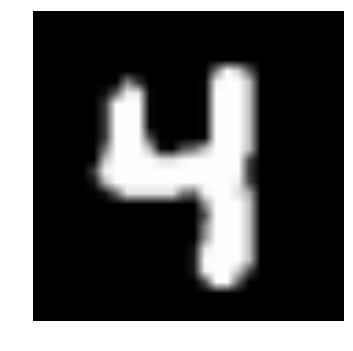

In [37]:
displaychar(train_data[58])

In [38]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

In [40]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ###
    for label in range(10):
        indices = (y == label)
        mu[label] = np.mean(x[indices,:], axis = 0)
        sigma[label] = np.cov(x[indices,:], rowvar = 0, bias = 1)
        pi[label] = float(sum(indices))/ float(len(y))
    ###
    # Halt and return parameters
    return mu, sigma, pi

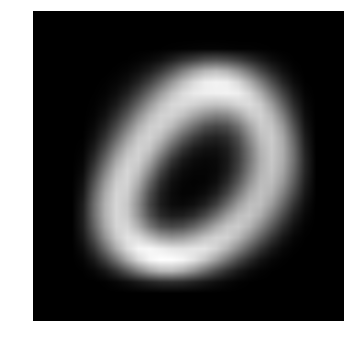

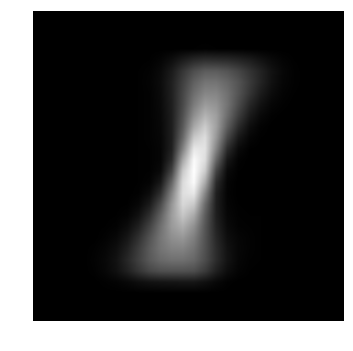

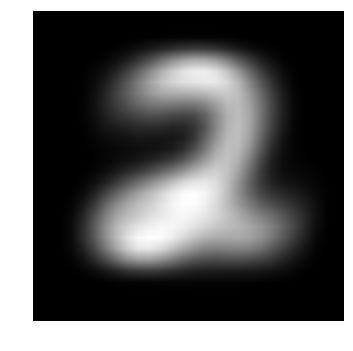

In [47]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

In [50]:
def regularization(sigma):
    for i in range(10):
        sigma[i][np.diag_indices((train_data.shape)[1])] += 3900
    return sigma

In [51]:
sigma = regularization(sigma)

In [52]:
# Compute log Pr(label|image) for each [test image,label] pair.
k = 10
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
        score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print ("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 431 errors out of 10000
